# M-Estimation to the Limit

In [417]:
from numpy import array
from matplotlib import pyplot as plot
from math import exp, sqrt
from scipy.optimize import curve_fit, minimize
from random import gauss, uniform

from LocUtil import Grid1, SetSeed

In [390]:
nSamp = 50
sigma = 0.5

nPlot = 101
figSize = (9, 6.5)

givenSeed = None

maxX = 7

In [391]:
k0 = 10
k1 = 1
ka = 2
kb = 1

In [392]:
func = lambda x: k1*x + k0 + ka/x + kb/x**2

In [393]:
seed = SetSeed(givenSeed)
if givenSeed is None:
	print(f'seed = {seed}')

sampX = [uniform(1,maxX) for _ in range(nSamp)]
sampY = [func(x) + sigma*gauss() for x in sampX]

seed = 93410


Text(0, 0.5, 'F(x)')

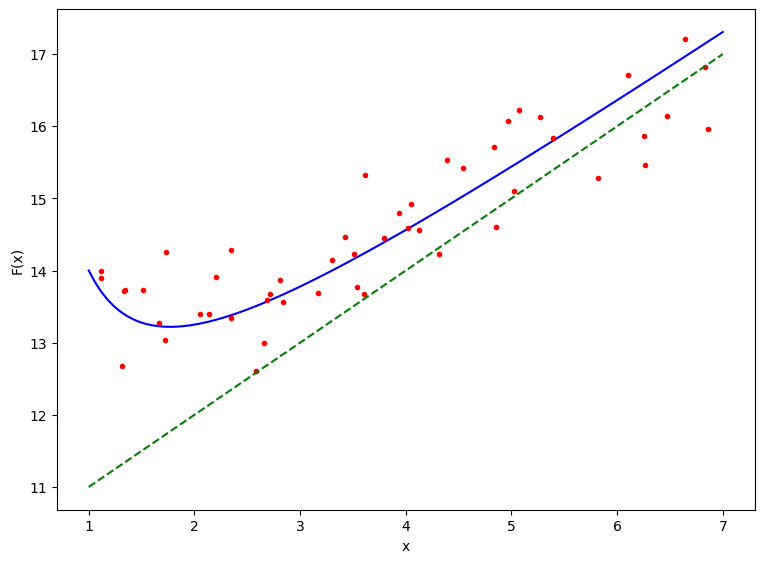

In [394]:
plot.subplots(1,1, figsize=figSize)

xGrid = Grid1(1,maxX, nPlot)
yGrid = [func(x) for x in xGrid]

plot.plot(xGrid, yGrid, c='blue')

plot.plot(sampX, sampY, '.', c='red')

asymGrid = [x + 10 for x in xGrid]
plot.plot(xGrid,asymGrid, '--',c="green")

plot.xlabel('x')
plot.ylabel('F(x)')

In [395]:
fOverX = [y / x for (x,y) in zip(sampX,sampY)]

Text(0, 0.5, 'F(x) / x')

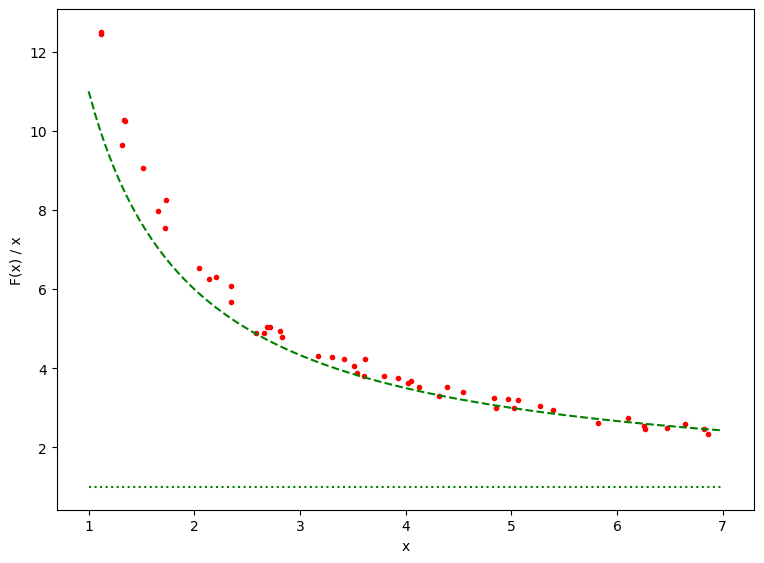

In [396]:
plot.subplots(1,1, figsize=figSize)

plot.plot(sampX,fOverX, '.', c='red')

asymOverX = [1 + 10/x for x in xGrid]
plot.plot(xGrid,asymOverX, '--', c='green')

plot.plot((1,maxX), (1,1), ':', c='green')

plot.xlabel('x')
plot.ylabel('F(x) / x')

## Standard Projection

### The Two Parameter Model (i.e., the same degree as the asymptote)

In [397]:
def fCurve2(x, k1,k0):
	return k1*x + k0

In [398]:
fFit = curve_fit(fCurve2, sampX,sampY)

In [399]:
k1Est2,k0Est2 = tuple(fFit[0])
k1Est2,k0Est2

(0.5945891694553103, 12.366083762491602)

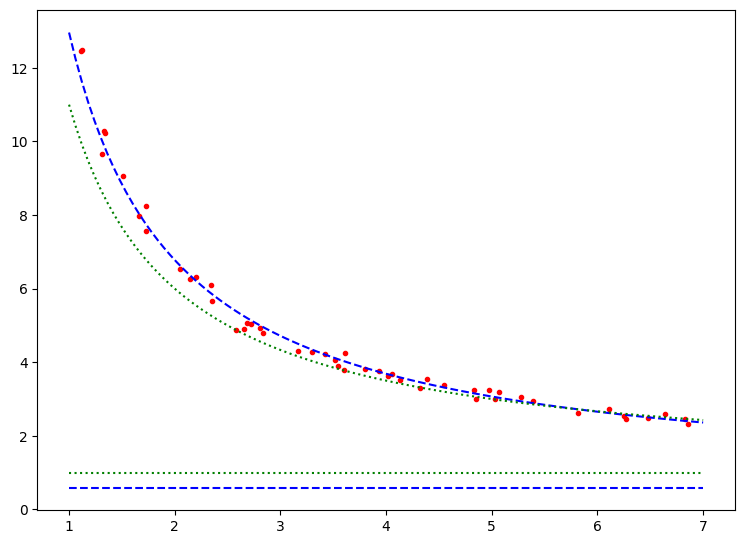

In [400]:
plot.subplots(1,1, figsize=figSize)

plot.plot(sampX,fOverX, '.', c='red')

est2Grid = [(k1Est2*x + k0Est2)/x for x in xGrid]
plot.plot(xGrid, est2Grid, '--', c="blue")
plot.plot((1,maxX), (k1Est2,k1Est2), '--', c='blue')

asymOverX = [1 + 10/x for x in xGrid]
plot.plot(xGrid,asymOverX, ':', c='green')
plot.plot((1,maxX), (1,1), ':', c='green')

In [401]:
### The Three Parameter Model (i.e., one more than the asymptote)

In [402]:
def fCurve3(x, k1,k0,ka):
	return k1*x + k0 + ka/x

In [403]:
fFit = curve_fit(fCurve3, sampX, sampY)
k1Est3, k0Est3, kaEst3 = tuple(fFit[0])
k1Est3, k0Est3, kaEst3

(0.8622384064304865, 10.487601146503955, 2.5429082768897264)

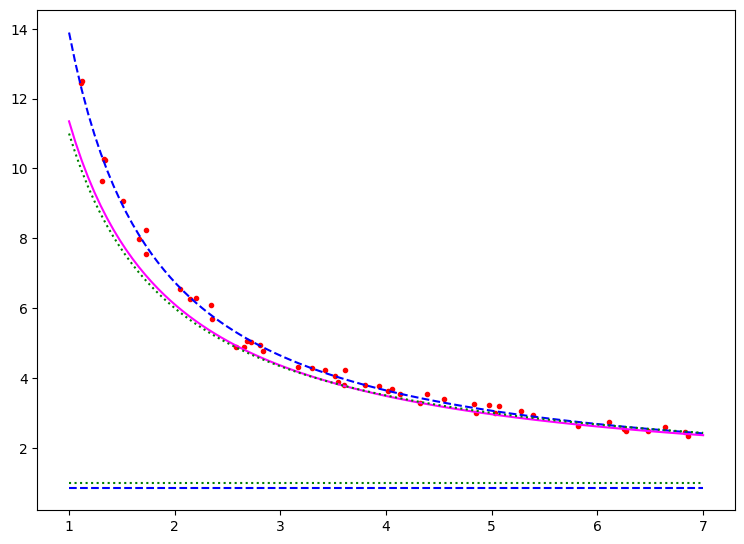

In [404]:
plot.subplots(1,1, figsize=figSize)

plot.plot(sampX,fOverX, '.', c='red')

est3Grid = [(k1Est3*x + k0Est3 + kaEst3/x)/x for x in xGrid]
plot.plot(xGrid, est3Grid, '--', c="blue")
plot.plot((1,maxX), (k1Est3,k1Est3), '--', c='blue')

asymGrid = [(k1Est3*x + k0Est3)/x for x in xGrid]
plot.plot(xGrid, asymGrid, c="magenta")

asymOverX = [1 + 10/x for x in xGrid]
plot.plot(xGrid,asymOverX, ':', c='green')
plot.plot((1,maxX), (1,1), ':', c='green')

## M-Estimators

#### Weight by X

In [405]:
def fCost0(k, x,y):
	k1,k0,ka = k
	
	diff = k1*x + k0 + ka/x - y
	cost = sum(abs(diff * x))
	
	return cost

In [406]:
kStart = array((k1Est3,k0Est3,kaEst3))

In [407]:
minRes = (minimize(fCost0, kStart, args=(array(sampX), array(sampY))))
minRes.x

array([ 0.88132077, 10.35247715,  2.85636296])

#### Only the upper x

In [408]:
def fCost1(k, x,y):
	k1,k0,ka = k
	
	diff = k1*x + k0 + ka/x - y
	cost = sum(abs(diff * (4 < x)))
	
	return cost

In [409]:
minRes = (minimize(fCost1, kStart, args=(array(sampX), array(sampY))))
minRes.x

array([ 0.87472727, 10.48409062,  2.52773025])

In [410]:
#### Only Close X

In [411]:
def fCost2(k, x,y):
	k1,k0,ka = k
	siogma = 0.5
	
	diff = k1*x + k0 + ka/x - y
	absDiff = abs(diff)
	cost = tuple(ad/sigma * exp(-ad/sigma) for ad in absDiff)
	
	return sum(cost)

In [412]:
minRes = (minimize(fCost2, kStart, args=(array(sampX), array(sampY))))
minRes.x

array([ 2.33805291, 15.46854988,  6.00812174])

#### Weight by x^2

In [413]:
def fCost3(k, x,y):
	k1,k0,ka = k
	
	diff = k1*x + k0 + ka/x - y
	absDiff = abs(diff)
	cost = absDiff * x**2
	
	return sum(cost)

In [414]:
minRes = (minimize(fCost3, kStart, args=(array(sampX), array(sampY))))
minRes.x

array([ 0.64216707, 11.93969776,  0.30712396])

#### Weight by sqrt(x)

In [426]:
def fCost4(k, xL,yL):
	k1,k0,ka = k
	
	diff = k1*xL + k0 + ka/xL - yL
	absDiff = abs(diff)
	cost = tuple(ad * sqrt(x) for (x,ad) in zip(absDiff,xL))
	
	return sum(cost)

In [427]:
fCost4(kStart, array(sampX), array(sampY))

113.88714954616411

In [428]:
minRes = (minimize(fCost4, kStart, args=(array(sampX), array(sampY))))
minRes.x

array([ 0.86568403, 10.48828438,  2.54306805])